# Проект: Анализ бизнес-показателей продукта

У вас в распоряжении есть данные от продукта "A" с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта продукта "A",
выгрузка всех заказов за этот период,
статистика рекламных расходов. Задача: помочь маркетологам оптимизировать маркетинговые затраты.

## Содержание работы:

1. [Предобработка данных](#start)

2. [Продуктовые метрики](#prod)
    - [DAU, WAU, MAU](#AU)
    - [Количество сессий на одного пользователя](#ds)
    - [Средняя продолжительность сессии (ASL)](#ASL)
    - [Retantion Rate](#RR)


3. [Продажи](#sales)
    - [Период первой покупки](#first_order)
    - [Количество покупок за период и средний чек](#month_stat)
    - [Пожизненная ценность клиента (LTV)](#LTV)


4. [Маркетинг](#marceting)
    - [Затраты на маркетинг](#m_costs)
    - [Затраты на привлечение 1 пользователя (CAC)](#CAC)
    - [Окупаемость затрат на маркетинг (ROMI)](#ROMI)


5. [Общий вывод](#end)


## Предобработка данных <a id="start"></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [5]:
# Заменим некорректные типы данных
visits[['End Ts', 'Start Ts']] = visits[['End Ts', 'Start Ts']].apply(pd.to_datetime)
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [6]:
# Уберем пробелы в названиях и приведем их к нижнему регистру
visits = visits.rename(columns={'End Ts':'end_ts','Start Ts':'start_ts', 'Source Id':'source_id'})
orders = orders.rename(columns={'Buy Ts':'buy_ts'})

visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)

In [7]:
print(visits.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  


## Расчет метрик

### Продуктовые метрики <a id="prod"></a>

**КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ** <a id="AU"></a>

Сколько людей пользуются в день, неделю, месяц?

Для расчета кол-ва пользователей, рассчитаем метрики: DAU, MAU, WAU.

In [8]:
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year

In [9]:
dau_total = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print('Среднее кол-во уникальных пользователей в день (DAU): {}'.format(int(dau_total)))
print('Среднее кол-во уникальных пользователей в неделю (WAU): {}'.format(int(wau_total)))
print('Среднее кол-во уникальных пользователей в месяц (MAU): {}'.format(int(mau_total)))

Среднее кол-во уникальных пользователей в день (DAU): 907
Среднее кол-во уникальных пользователей в неделю (WAU): 5716
Среднее кол-во уникальных пользователей в месяц (MAU): 23228


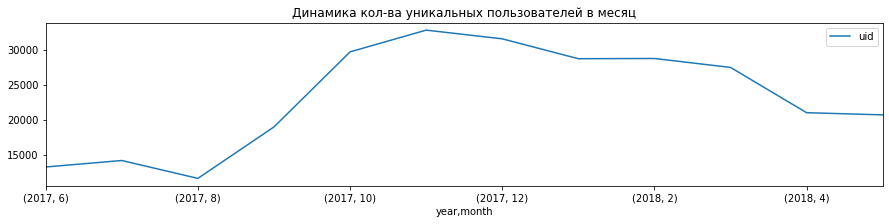

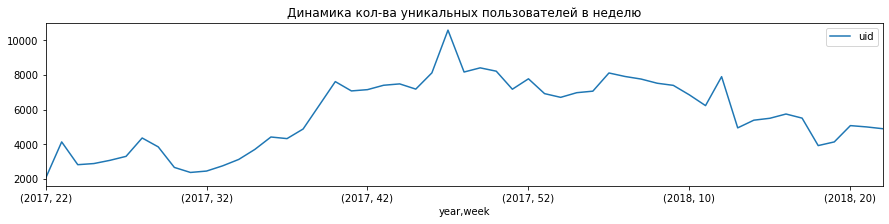

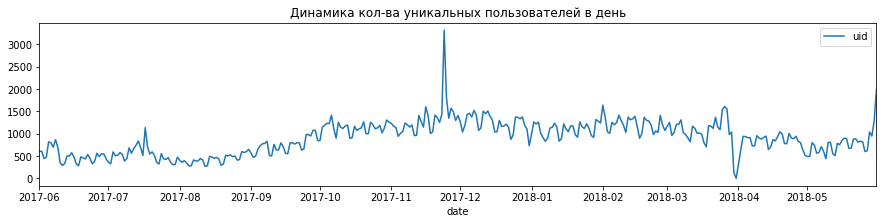

In [10]:
visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).plot(figsize=(15,3))
plt.title('Динамика кол-ва уникальных пользователей в месяц')
plt.show()
visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).plot(figsize=(15,3))
plt.title('Динамика кол-ва уникальных пользователей в неделю')
plt.show()
visits.groupby('date').agg({'uid': 'nunique'}).plot(figsize=(15,3))
plt.title('Динамика кол-ва уникальных пользователей в день')
plt.show()

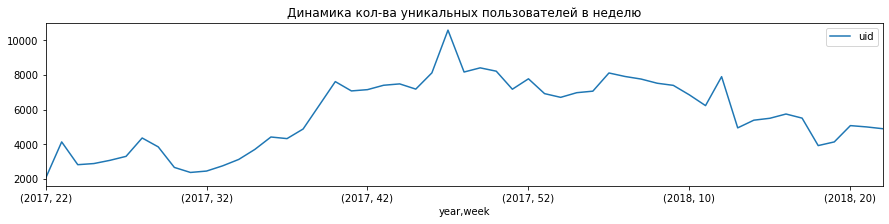

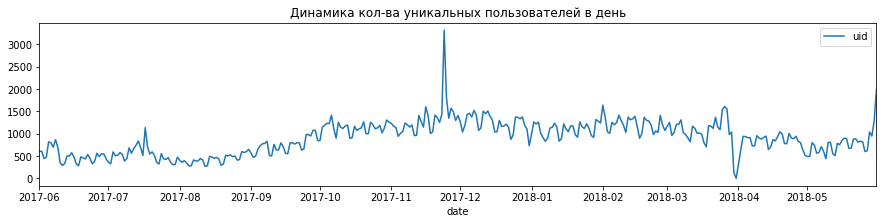

In [11]:
visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).plot(figsize=(15,3))
plt.title('Динамика кол-ва уникальных пользователей в неделю')
plt.show()
visits.groupby('date').agg({'uid': 'nunique'}).plot(figsize=(15,3))
plt.title('Динамика кол-ва уникальных пользователей в день')
plt.show()

Из графиков видно, что кол-во пользователей равномерно увеличивалось до конца 2017 года, в 2018 кол-во начало снижаться.


**КОЛИЧЕСТВО СЕССИЙ НА ОДНОГО ПОЛЬЗОВАТЕЛЯ** <a id="ds"></a>

Сколько сессий в день?

In [12]:
day_sessions = visits.groupby(['date']).agg({'uid': ['count','nunique']})
day_sessions.columns = ['n_sessions', 'n_users']

day_sessions[['n_sessions', 'n_users']] = day_sessions[['n_sessions', 'n_users']]
day_sessions['sessions_per_user'] = day_sessions['n_sessions'] / day_sessions['n_users']

In [13]:
day_sessions

,n_sessions,n_users,sessions_per_user
date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


In [14]:
print('Среднее кол-во сессий в день: {:.2f}'.format(day_sessions['sessions_per_user'].mean()))

Среднее кол-во сессий в день: 1.08


**СРЕДНЯЯ ПРОДОЛЖИТЕЛЬНОСТЬ СЕССИИ (ASL)** <a id="ASL"></a>

Сколько длится одна сессия?

In [15]:
visits['ASL'] =  (visits['end_ts'] - visits['start_ts']).dt.seconds
# рассчитаем среднее значение
visits['ASL'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: ASL, dtype: float64

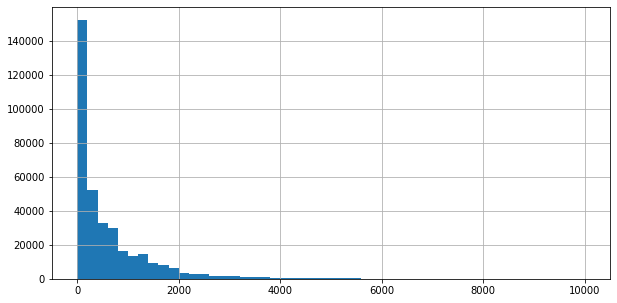

In [16]:
# проверим распределение на графике
visits['ASL'].hist(bins=50, range=(0,10000), figsize=(10,5))
plt.show()

Длина сессий распределена неравномерно, поэтому вместо среднего значения рассчитаем наиболее часто встречающееся.

In [17]:
print(visits['ASL'].mode())

0    60
dtype: int64


Чаще всего пользователи проводят на сайте около 1 минуты.

**ПОВТОРНЫЕ ЗАХОДЫ** <a id="RR"></a>

Как часто люди возвращаются?

Рассчитаем Retention Rate, чтобы определить, как часто пользователи возвращаются.

n-период/0-период*100

In [18]:
# вычислим дату первой покупки и добавим ее к исходной таблице
first_users_session = visits.groupby('uid')['start_ts'].min()
first_users_session.name = 'first_session'
visits = visits.join(first_users_session, on='uid')

In [19]:
# выделим месяц в формате даты для формирования когорты
visits['first_session_month'] = visits['first_session'].astype('datetime64[M]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

In [20]:
cohorts = visits.groupby(['first_session_month', 'session_month'])['uid'].nunique().reset_index()
cohorts['age'] = ((cohorts['session_month'] - cohorts['first_session_month'])/np.timedelta64(1,'M')).round().astype('int')

initial_cnt = cohorts.query('age == 0')[['first_session_month', 'uid']]
initial_cnt = initial_cnt.rename(columns={'uid':'cnt_users'})

cohorts = cohorts.merge(initial_cnt, on='first_session_month')
cohorts

,first_session_month,session_month,uid,age,cnt_users
0,2017-06-01,2017-06-01,13259,0,13259
1,2017-06-01,2017-07-01,1043,1,13259
2,2017-06-01,2017-08-01,713,2,13259
3,2017-06-01,2017-09-01,814,3,13259
4,2017-06-01,2017-10-01,909,4,13259
...,...,...,...,...,...
73,2018-03-01,2018-04-01,861,1,20589
74,2018-03-01,2018-05-01,557,2,20589
75,2018-04-01,2018-04-01,15709,0,15709
76,2018-04-01,2018-05-01,760,1,15709


In [21]:
cohorts['retention'] = (cohorts['uid']/cohorts['cnt_users'])
cohorts['first_session_month'] = cohorts['first_session_month'].dt.strftime('%Y-%m')

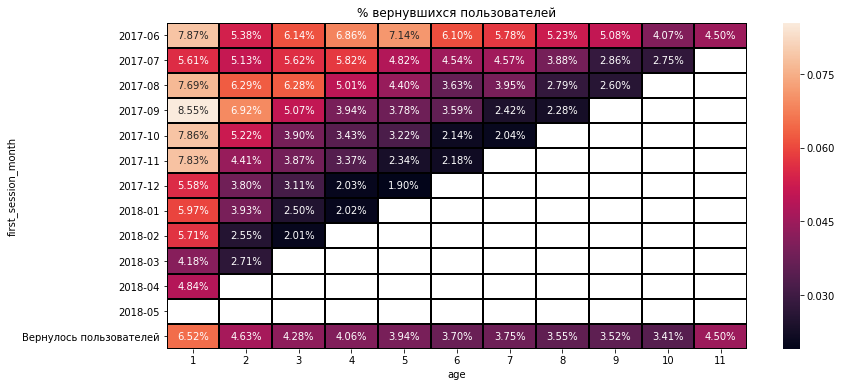

In [22]:
cohorts_pivot = cohorts.pivot_table(
                index='first_session_month',
                columns='age',
                values='retention',
                aggfunc='mean',
                margins=True, margins_name = 'Вернулось пользователей')

cohorts_pivot = cohorts_pivot.iloc[:, 1:-1]

plt.figure(figsize=(13, 6)) 
plt.title('% вернувшихся пользователей') 
sns.heatmap(cohorts_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='black')
plt.show()

В среднем на слудющий месяц после 1-го захода возвращается 6,5% пользователей, в последующие месяца показатель постепенно снижается.

### Продажи <a id="sales"></a>

**ПЕРИОД ПЕРВОЙ ПОКУПКИ** <a id="first_order"></a>

Когда люди начинают покупать? 

In [23]:
first_order = orders.pivot_table(index='uid', values='buy_ts', aggfunc='min')
first_order = first_order.merge(first_users_session, on='uid')
first_order

,buy_ts,first_session
uid,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...
18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00
18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00
18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00


In [24]:
first_order['from_session_to_order'] = (first_order['buy_ts'] - first_order['first_session'])/np.timedelta64(1,'m')

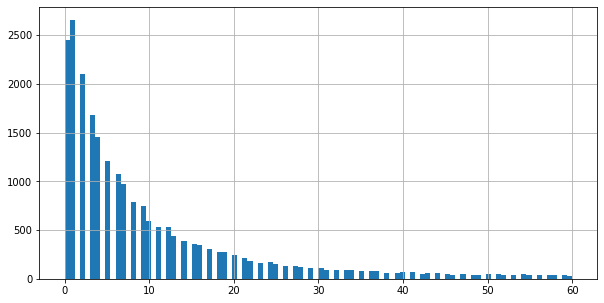

In [25]:
first_order['from_session_to_order'].hist(bins=100, range=(0,60), figsize=(10,5))
plt.show()

Очень много значений приходится на 0 дельту, вероятнее всего это заказы совершенные за период менее 1 минуты после начала сессии. Также стоит обратить внимание на то, что распределение далеко от нормального, в этом случае лучше взять наиболее частое значение, а не медиану.

In [26]:
print(first_order['from_session_to_order'].mode())
first_order['from_session_to_order'].describe()

0    1.0
dtype: float64


count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: from_session_to_order, dtype: float64

В среднем пользователи Афиши совершают первую покупку через 16 минут после начала сессии, а самое частое время заказа от 1 до 2 минут.

**КОЛИЧЕСТВО ПОКУПОК ЗА ПЕРИОД И СРЕДНИЙ ЧЕК** <a id="month_stat"></a>

Сколько раз покупают за период? Какой средний чек?

Среднее кол-во покупок за все время: 1.38


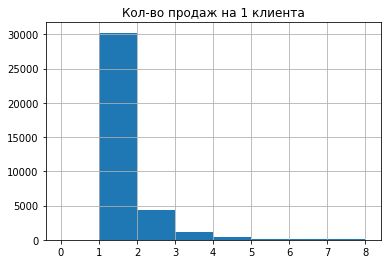

In [27]:
# посмотрим сколько покупок обычно совершают пользователи за весь срок жизни
print('Среднее кол-во покупок за все время: {:.2f}'.format((orders.groupby('uid')['uid'].count()).mean()))

orders.groupby('uid')['uid'].count().hist(bins=8, range=(0,8))
plt.title('Кол-во продаж на 1 клиента')
plt.show()

Рассчитаем общий средний чек за все время.

In [28]:
print('Средний чек на клиента за все время: {:.1f} $'.format(orders['revenue'].sum()/orders['uid'].nunique()))
print('Средний чек на заказ за все время: {:.1f} $'.format(orders['revenue'].sum()/orders['uid'].count()))

Средний чек на клиента за все время: 6.9 $
Средний чек на заказ за все время: 5.0 $


Чек заказа и чек на клиента отличаются незначительно.
Посмотрим изменение чеков и кол-ва продаж по календарным периодам.

In [29]:
# рассчитаем общее кол-во продаж в месяц
orders['order_month'] = orders['buy_ts'].dt.strftime('%Y-%m')
monthly_orders = orders.groupby('order_month').agg({'uid':['nunique', 'count'], 'revenue':'sum'}) 
monthly_orders.columns = ['uid_cnt', 'orders_cnt', 'revenue']
monthly_orders = monthly_orders.reset_index()

# считаем кол-во продаж на клиента в месяц
monthly_orders['orders_per_uid'] = (monthly_orders['orders_cnt']/monthly_orders['uid_cnt']).round(2)
# добавим инфу о чеке продажи
monthly_orders['client_avg_check'] = (monthly_orders['revenue']/monthly_orders['uid_cnt']).round(2)
monthly_orders

,order_month,uid_cnt,orders_cnt,revenue,orders_per_uid,client_avg_check
0,2017-06,2023,2354,9557.49,1.16,4.72
1,2017-07,1984,2363,12539.47,1.19,6.32
2,2017-08,1472,1807,8758.78,1.23,5.95
3,2017-09,2750,3387,18345.51,1.23,6.67
4,2017-10,4675,5679,27987.70,1.21,5.99
5,2017-11,4547,5659,27069.93,1.24,5.95
6,2017-12,4942,6218,36388.60,1.26,7.36
7,2018-01,3898,4721,19417.13,1.21,4.98
8,2018-02,4258,5281,25560.54,1.24,6.00
9,2018-03,4181,5326,28834.59,1.27,6.90


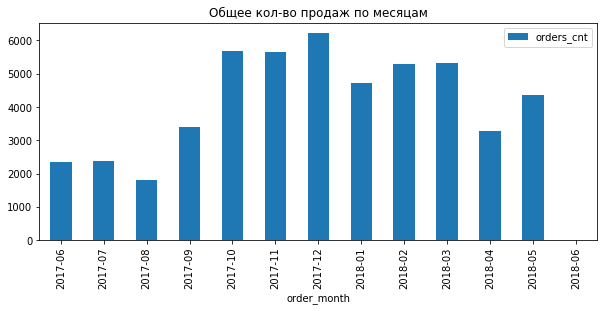

In [30]:
monthly_orders.pivot_table(index='order_month', values='orders_cnt').plot(kind='bar', figsize=(10,4))
plt.title('Общее кол-во продаж по месяцам')
plt.show()

Исходя из графиков можно сделать вывод, что среднее кол-во покупок на 1 пользователя по году практически не отличается, а вот общее кол-во продаж в период с октября по декабрь выше, чем в остальные периоды.

Для дальнейших расчетов соберем данные по **когортам**.

In [31]:
# добавим данные о первой дате покупки, чтобы сформировать когорту
first_order.columns = ['first_order_date', 'first_session_date', 'from_session_to_order']
first_order = first_order.reset_index()

In [32]:
orders = orders.merge(first_order, on='uid')

In [33]:
# также добавим инфу о первом источнике и девайсе, для дальнейших расчетов
first_source_device = visits.groupby(['uid', 'first_session'])['source_id', 'device'].first().reset_index()
first_source_device.columns = ['uid', 'first_session', 'first_source_id', 'first_device']
first_source_device = first_source_device.loc[:, ['uid', 'first_source_id', 'first_device']]

In [34]:
orders = orders.merge(first_source_device, on='uid')

In [35]:
orders.head(1)

,buy_ts,revenue,uid,order_month,first_order_date,first_session_date,from_session_to_order,first_source_id,first_device
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06,2017-06-01 00:10:00,2017-06-01 00:09:00,1.0,1,desktop


In [36]:
# проверим уникальность объединенных значений
(orders.groupby(['uid', 'first_order_date', 'first_session_date', 'first_source_id', 'first_device'])['uid'].nunique()).sum()

36523

Теперь можно приступить к формированию когорты по дате 1 покупки:

In [37]:
orders['order_month'] =  orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] =  orders['first_order_date'].astype('datetime64[M]')
orders['age'] = ((orders['order_month'] - orders['first_order_month'])/np.timedelta64(1,'M')).round().astype('int')
orders.head(2)

,buy_ts,revenue,uid,order_month,first_order_date,first_session_date,from_session_to_order,first_source_id,first_device,first_order_month,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:09:00,1.0,1,desktop,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:14:00,11.0,2,desktop,2017-06-01,0


In [38]:
orders_group = orders.groupby(['first_order_month', 'age', 'first_source_id', 'first_device'])\
                        .agg({'uid':['nunique', 'count'], 'revenue':'sum'})
orders_group.columns = ['customers_cnt', 'orders_cnt', 'revenue'] 
orders_group = orders_group.reset_index()
orders_group

,first_order_month,age,first_source_id,first_device,customers_cnt,orders_cnt,revenue
0,2017-06-01,0,1,desktop,169,223,1035.53
1,2017-06-01,0,1,touch,34,44,132.92
2,2017-06-01,0,2,desktop,223,288,1302.57
3,2017-06-01,0,2,touch,48,59,249.19
4,2017-06-01,0,3,desktop,503,542,2237.20
...,...,...,...,...,...,...,...
893,2018-05-01,0,9,desktop,43,45,172.35
894,2018-05-01,0,9,touch,10,11,28.03
895,2018-05-01,0,10,desktop,85,94,381.37
896,2018-05-01,0,10,touch,32,39,97.56


Посмотрим на чеки в разрезе когорт.

In [39]:
# собираем таблицу общих показателей по когортам
cohort_avg_check = orders_group.pivot_table(
                    index='first_order_month', 
                    values = ['customers_cnt', 'orders_cnt', 'revenue'], 
                    aggfunc='sum')
cohort_avg_check.columns = ['customers_cnt', 'orders_cnt', 'revenue']

cohort_avg_check['client_check'] = (cohort_avg_check['revenue']/cohort_avg_check['customers_cnt']).round(2)
cohort_avg_check['order_check'] = (cohort_avg_check['revenue']/cohort_avg_check['orders_cnt']).round(2)
cohort_avg_check

,customers_cnt,orders_cnt,revenue,client_check,order_check
first_order_month,,,,,
2017-06-01,2653,4438,24031.69,9.06,5.41
2017-07-01,2348,2910,16127.92,6.87,5.54
2017-08-01,1721,2188,11606.26,6.74,5.30
2017-09-01,3147,3878,34676.32,11.02,8.94
2017-10-01,5049,6005,27603.45,5.47,4.60
2017-11-01,4720,5900,26098.99,5.53,4.42
2017-12-01,4842,5894,33485.74,6.92,5.68
2018-01-01,3658,4308,16663.13,4.56,3.87
2018-02-01,3866,4470,16750.50,4.33,3.75


<Figure size 432x288 with 0 Axes>

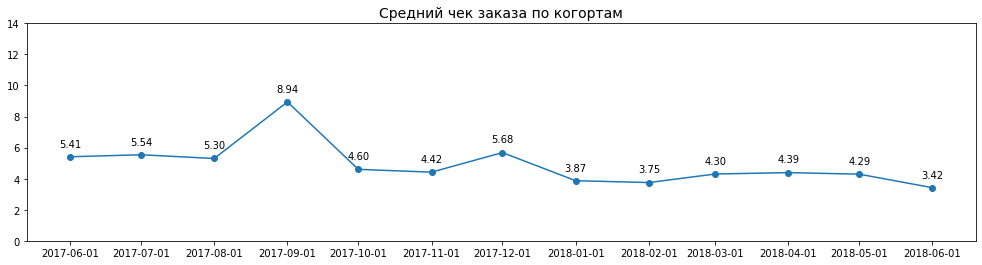

In [40]:
# посмотрим на графике, как отличается чек по когортам
gr = cohort_avg_check.loc[:, ['client_check', 'order_check']].reset_index()
plt.clf()

xs = gr['first_order_month']
ys = gr['order_check']

plt.figure(figsize=(17,4))
plt.title('Средний чек заказа по когортам', fontsize = 14)
plt.plot(xs,ys,'o-')

# напием функцию, чтобы добавить подписи на график по координамтам точки
for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)
    plt.annotate(label, 
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.xticks(gr['first_order_month'])
plt.yticks(np.arange(0,15,2))

plt.show()

Исходя из графика видно, что средний чек от когорты к когорте постепенно снижается, самый высокий чек у клиентов сентября 2019 года.

**LTV** <a id="LTV"></a>

Сколько денег приносят?

LTV - это совокупная прибыль компании, получаемая от одного клиента за все время сотрудничества с ним. LTV рассчитывается от валовой прибыли, но т.к. у нас нет информации по себестоимости, поэтому примем условный **к-т маржинальности 0,5**.

LTV = Валовая прибыль когорты / первоначальное кол-во клиентов в когорте

In [41]:
margin_rate = 0.5

# рассчитаем валовую прибыль
orders_group['gross_profit'] = orders_group['revenue']*margin_rate

In [42]:
# считаем первоначальное кол-во пользователей и добавляем к таблице общих показателей
n_customers = orders_group.query('age == 0')[['first_order_month', 'first_source_id', 'first_device', 'customers_cnt']]
n_customers = n_customers.rename(columns={'customers_cnt' : 'n_customers'})
orders_group = orders_group.merge(n_customers, on=['first_order_month', 'first_source_id', 'first_device'], how='outer')

In [43]:
# рассчитаем валовую прибыль на пользователя в периоде для расчета LTV
cohorts_orders = orders_group.groupby(['first_order_month', 'age']).agg({'gross_profit':'sum', 'n_customers':'sum'})
cohorts_orders = cohorts_orders.reset_index()
cohorts_orders['cohort_month'] = cohorts_orders['first_order_month'].dt.strftime('%Y-%m')
cohorts_orders['gp_per_client'] = cohorts_orders['gross_profit']/cohorts_orders['n_customers']
cohorts_orders.head(1)

,first_order_month,age,gross_profit,n_customers,cohort_month,gp_per_client
0,2017-06-01,0,4778.745,2023,2017-06,2.362207


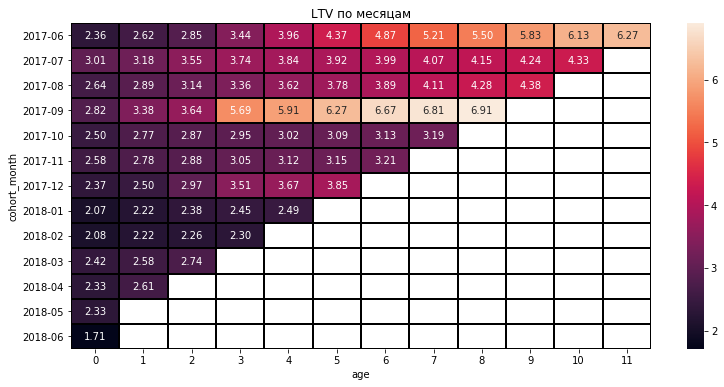

In [44]:
# рассчитаем LTV по каждой когорте
LTV_final = cohorts_orders.pivot_table(
            index='cohort_month', 
            columns='age', 
            values='gp_per_client', 
            aggfunc='sum').cumsum(axis=1).round(2) 

plt.figure(figsize=(13, 6)) 
plt.title('LTV по месяцам') 
sns.heatmap(LTV_final, annot=True, fmt='.2f', linewidths=1, linecolor='black')
plt.show()

Для того, чтобы рассчитать общий LTV по всем когортам, нужно понимать средний срок жизни клиента и считать показатель по когортам достигшим этого "возраста". Т.к. у нас ограниченный набор данных возьмем когорты, которые прожили хотя бы 6 месяцев - половину максимального срока жизни.

In [45]:
cumulative_ltv = cohorts_orders.query('first_order_month <= 20171201').pivot_table(
            index='first_order_month', 
            columns='age', 
            values='gp_per_client', 
            aggfunc='sum').mean(axis=0).cumsum()[5]

print('В среднем 1 клиент приносит компании: {:.2f} $'.format(cumulative_ltv))

В среднем 1 клиент приносит компании: 4.06 $


### Маркетинг <a id="marceting"></a>

Сколько денег потратили? Всего / на каждый источник / по времени

**ЗАТАРТЫ НА МАРКЕТИНГ** <a id="m_costs"></a>

In [46]:
print('Общие расходы на маркетинг: {:.2f} $'.format(costs['costs'].sum()))

Общие расходы на маркетинг: 329131.62 $


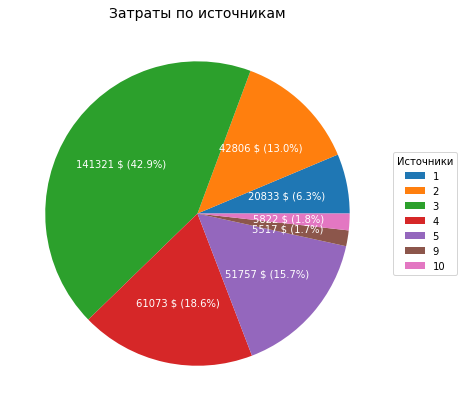

In [47]:
# рассчитаем расходы в разрезе источников
costs_by_sourse = costs.groupby('source_id')['costs'].sum()

fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:d} $ ({:.1f}%)".format(absolute, pct)

wedges, texts, autotexts = ax.pie(costs_by_sourse, autopct=lambda pct: func(pct, costs_by_sourse),
                                  textprops=dict(color="w"))
ax.legend(wedges, costs_by_sourse.index,
          title="Источники",
          loc="center left",
          bbox_to_anchor=(1, 0, 1, 1))

plt.setp(autotexts, size=10)
ax.set_title('Затраты по источникам', fontsize=14)
plt.show()

Большая часть расходов уходить на источник № 3.

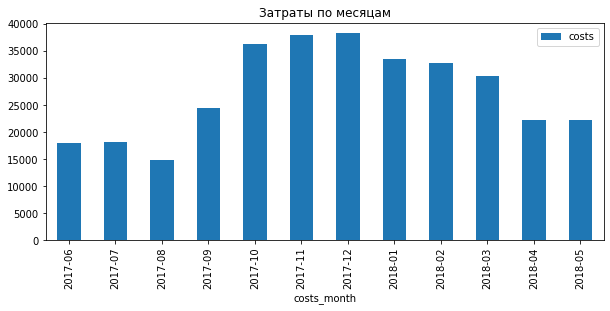

In [48]:
costs['costs_month'] = costs['dt'].dt.strftime('%Y-%m')
costs.pivot_table(index='costs_month', values='costs', aggfunc='sum')\
        .plot(kind='bar', figsize=(10,4), title = 'Затраты по месяцам')
plt.show()

### CAC <a id="CAC"></a>
Сколько стоило привлечение одного покупателя из каждого источника? САС

Нужно учесть, что для расчета LTV мы брали когорты прожившие 6 и более месяцев. 

Чтобы данные для расчета окупаемости были сопоставимы, **САС будем считать по тем же когортам (01.06.2017 - 01.12.17)**.

In [49]:
# переведем исходную дату в месячный тип для дальнейших группировок
costs['dt'] = costs['dt'].astype('datetime64[M]')

In [50]:
# добавим информацию по затратам на источник к общим данным
orders_group = orders_group.merge(
             # группируем данные по источнику и периоду   
            (costs.groupby(['source_id', 'dt'])['costs'].sum().reset_index()).rename(columns={'costs': 'costs_by_source'}), 
            left_on=['first_order_month', 'first_source_id'], 
            right_on=['dt', 'source_id'], 
            how='left') # т.к. в заказах у нас на 1 период и на 1 источник больше, используем тип соединения left

In [51]:
# добавим информацию по затратам в месяц к общим данным
orders_group = orders_group.merge(
            # группируем данные по периоду 
            (costs.groupby(['dt'])['costs'].sum().reset_index()),
            on='dt', how='left')
orders_group.head(2)

,first_order_month,age,first_source_id,first_device,customers_cnt,orders_cnt,revenue,gross_profit,n_customers,source_id,dt,costs_by_source,costs
0,2017-06-01,0,1,desktop,169,223,1035.53,517.765,169,1.0,2017-06-01,1125.61,18015.0
1,2017-06-01,1,1,desktop,9,60,287.78,143.890,169,1.0,2017-06-01,1125.61,18015.0


In [52]:
# добавим к LTV общие расходы
cohorts_orders = cohorts_orders.merge(
                (costs.groupby(['dt'])['costs'].sum().reset_index()),
                 left_on='first_order_month', right_on='dt')


cohorts_orders['costs_per_client'] = cohorts_orders['costs']/cohorts_orders['n_customers']
cohorts_orders['romi'] = cohorts_orders['gp_per_client']/cohorts_orders['costs_per_client']

In [53]:
# рассчитаем средние затраты на 1 пользователя по источникам
# добавляем фильтр на период (01.06.2017 - 01.12.17) по выбранным для расчета ltv когортам
CAC = orders_group.query('age == 0  & first_order_month <= 20171201').groupby(['first_source_id', 'first_order_month'])\
                    .agg({'costs_by_source':'mean', 'n_customers':'sum'}).reset_index()
CAC['cac'] = CAC['costs_by_source']/CAC['n_customers']

сас_by_source = CAC.groupby(['first_source_id'])['cac'].mean().reset_index().round(2)
сас_by_source

,first_source_id,cac
0,1,5.53
1,2,9.85
2,3,16.19
3,4,7.27
4,5,7.36
5,7,NaN
6,9,3.55
7,10,6.04


In [54]:
CAC['costs_by_source'].sum().round(2) # общие затраты по 7 когортам

187961.15

In [55]:
# рассчитаем общие затраты на 1 пользователя
print('Общие затраты на 1 пользователя равны: {:.2f}'.format(
    CAC['costs_by_source'].sum()/orders_group.query('age == 0 & first_order_month <= 20171201')['n_customers'].sum())
     )

Общие затраты на 1 пользователя равны: 9.08


### ROMI <a id="ROMI"></a>
На сколько окупились расходы?

Для проверки окупаемости рассчитаем ROMI - показатель возврата инвестиций маркетинговых каналов.

ROMI = LTV / CAC. 
Для того чтобы посчитать окупаемость источника, необходимо сначала рассчитать LTV по каждому из них.

In [56]:
# рассчитаем общий ROMI по проекту
ROMI = cumulative_ltv/(CAC['costs_by_source'].sum()/orders_group
                .query('age == 0 & first_order_month <= 20171201')['n_customers'].sum())

print('Общая окупаемость инвестиций: {:.2f}'.format(ROMI))

Общая окупаемость инвестиций: 0.45


In [57]:
# посмотрим на окупаемость по когортам

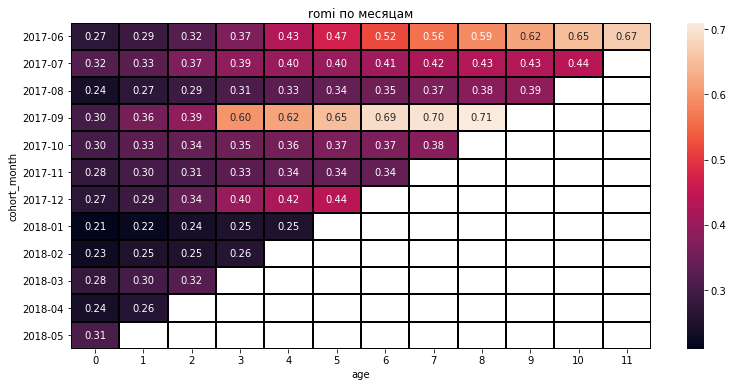

In [58]:
romi_by_month = cohorts_orders.pivot_table(
                                index='cohort_month',
                                columns = 'age',
                                values = 'romi',
                                            ).cumsum(axis=1).round(2) 

plt.figure(figsize=(13, 6)) 
plt.title('romi по месяцам') 
sns.heatmap(romi_by_month, annot=True, fmt='.2f', linewidths=1, linecolor='black')
plt.show()

In [59]:
# напишем функцию расчета ltv по источникам, т.к. расчет нужно делать по аналогии с общим ltv - накопительно по когортам
list_of_source = costs['source_id'].unique()

def ltv_calc(list_of_values):
    result = []
    for i in list_of_values:
        val = i
        cohorts = orders_group.query('first_source_id == @val')\
                            .groupby(['first_order_month', 'age']).agg({'gross_profit':'sum', 'n_customers':'sum'})
        cohorts = cohorts.reset_index()
        cohorts['gp_per_client'] = cohorts['gross_profit']/cohorts['n_customers']
        cohorts.head(2)

        cumulative_ltv = cohorts.query('first_order_month <= 20171201').pivot_table(
            index='first_order_month', 
            columns='age', 
            values='gp_per_client', 
            aggfunc='sum').mean(axis=0).cumsum()[5].round(2)
        result.append(cumulative_ltv)
    return result

# сохраним результат в таблицу
d1 = {'source': list_of_source, 'ltv': ltv_calc(list_of_source)}
ltv_by_source = pd.DataFrame(data=d1)

In [60]:
# объединим данные по ltv и cac для расчета romi
romi_source = сас_by_source.merge(ltv_by_source, left_on='first_source_id',right_on='source')

In [61]:
romi_source['romi'] = (romi_source['ltv']/romi_source['cac']).round(2)
romi_source = romi_source[['first_source_id', 'cac', 'ltv', 'romi']]

In [62]:
# соберем общую статистику по источникам
source_stat = (orders_group.groupby('first_source_id')
               .agg({'customers_cnt':'sum', 'orders_cnt':'sum', 'revenue':'sum'})
                            .round(2).reset_index())

source_stat = source_stat.merge(romi_source, on='first_source_id', how='left').fillna('')
source_stat = source_stat.merge(costs.groupby('source_id')['costs'].sum().reset_index(),
                                left_on = 'first_source_id',
                                right_on = 'source_id', 
                                how = 'left').fillna(0)

source_stat.drop('source_id', axis=1, inplace=True)
source_stat['gp'] = source_stat['revenue']*margin_rate
source_stat['np'] = source_stat['gp'] -  source_stat['costs'] # рассчитаем годовую прибыль по источникам за вычетом затрат
source_stat['avg_check'] = source_stat['revenue']/source_stat['orders_cnt']
source_stat['orders_per_client'] = source_stat['orders_cnt']/source_stat['customers_cnt']
source_stat

,first_source_id,customers_cnt,orders_cnt,revenue,cac,ltv,romi,costs,gp,np,avg_check,orders_per_client
0,1,4386,6679,38560.06,5.53,5.51,1,20833.27,19280.030,-1553.240,5.773328,1.522800
1,2,5319,7734,65152.26,9.85,9.94,1.01,42806.04,32576.130,-10229.910,8.424135,1.454033
2,3,9904,10941,44317.68,16.19,2.67,0.16,141321.63,22158.840,-119162.790,4.050606,1.104705
3,4,10893,12246,52479.75,7.27,2.95,0.41,61073.60,26239.875,-34833.725,4.285461,1.124208
4,5,7456,9310,40357.91,7.36,3.36,0.46,51757.10,20178.955,-31578.145,4.334899,1.248659
5,7,1,1,1.22,,,,0.00,0.610,0.610,1.220000,1.000000
6,9,1741,2053,7076.98,3.55,2.84,0.8,5517.49,3538.490,-1979.000,3.447141,1.179207
7,10,1319,1451,4111.34,6.04,1.9,0.31,5822.49,2055.670,-3766.820,2.833453,1.100076


Исходя из полученных данных можно сделать вывод, что при принятом коэффициенте маржинальности **0,5** по 7 выбранным когортам **окупаются только первые 2 источника**, общий к-т окупаемости по проекту равен <font color='red'> **45%** </font>. 

При этом источник № 3, на который приходятся самые высокие затраты на привлечение 1 пользователя имеет самый низкий % окупаемости. Из более прибыльных каналов можно выделить источники 1,2 и также можно поработать с источником № 9.

In [63]:
# посмотрим на показатели выручки по девайсам
device_stat = (orders_group.groupby('first_device')
               .agg({'customers_cnt':'sum', 'orders_cnt':'sum', 'revenue':'sum'})
                            .round(2).reset_index())
device_stat

,first_device,customers_cnt,orders_cnt,revenue
0,desktop,32985,40904,211531.81
1,touch,8034,9511,40525.39


Большую часть выручки приносят клиенты, используеющие компьютер.

### Общий вывод <a id="end"></a>

#### Шаг 3. Напишите вывод

Порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?
Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?


**Вывод:**

Один пользователь обычно совершает 1 сессию в день, средняя продолжительность сессии составляет 1 минуту. 
Самое частое время от начала сессии до первого заказа - 1-2 минут. Это может говорить о том, что пользователи заходят на сайт уже зная, что они хотят купить и не тратят время на выбор.

Основная часть пользователей использует для покупок тип девайса desktop, а не touch.

В среднем на слудющий месяц после 1-го захода возвращается всего 6,5% пользователей, в последующие месяца показатель постепенно снижается.

Средний чек заказа составляет 5 долл., в конце года чек немного выше, чем другие периоды. Аналогичную картину можно наблюдать и с количеством продаж - среднее кол-во покупок на 1 пользователя по году практически не отличается, а вот общее кол-во продаж в период с октября по декабрь выше, чем в остальные периоды.

Самый высокий средний чек у клиентов из когорты сентября 2019 года, он составляет 8,94 долл.

1 клиент приносит компании 4,09долл., а затарты на 1 клиента составляют - 9.08долл., в целом проект окупается всего на 45%.

Среди источников прибыльными являютмя только источники №1 и №2, также можно отметить, что у данных источников самые высокие средние чеки и кол-во продаж на 1 клиента. 
42% расходов приходится на источник № 3 с самым низким % окупаемости(16%), при этом по кол-ву клиентов этот источник находится на 2 месте.

**Рекомендации:**

В первую очередь нужно обратить внимание на распределение расходов по рекламным источникам:
- сократить расходы на источник № 3 и также поработать над увеличением среднего чека и кол-ва продаж на 1 пользователя, чтобы нивелировать его низкий % окупаемости
- увеличить финансирование источников 1 и 2
- поработать над увеличением чека клиентов 4 и 5 источников

Также у сервиса довольно низкий % повторных заходов/покупок, можно попытаться увеличить этот показатель
